<h3>12.3 Pytorch实现图像修复</h3>

<h3>12.3.1 网络结构</h3>

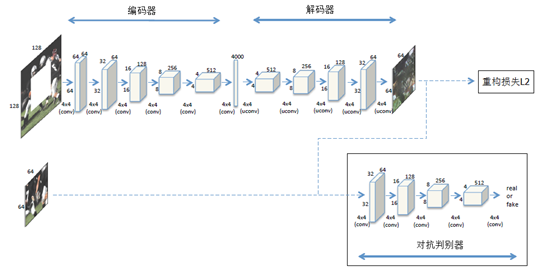

<h3>12.3.3 图像修复实例</h3>

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
parser = argparse.ArgumentParser(description='Process some params')
parser.add_argument('--dataset',  default='streetview', help='cifar10 | lsun | imagenet | folder | lfw ')
parser.add_argument('--test_image', default='pytorch_12_xf/test/001_im.png',required=False, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=4)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=128, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--nc', type=int, default=3)
parser.add_argument('--niter', type=int, default=50, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='pytorch_12_xf/model/netG_streetview.pth', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')

parser.add_argument('--nBottleneck', type=int,default=4000,help='of dim for bottleneck of encoder')
parser.add_argument('--overlapPred',type=int,default=4,help='overlapping edges')
parser.add_argument('--nef',type=int,default=64,help='of encoder filters in first conv layer')
parser.add_argument('--wtl2',type=float,default=0.999,help='0 means do not use else use with this weight')
opt = parser.parse_args(['--dataset', 'streetview'])
print(opt)

Namespace(batchSize=64, beta1=0.5, cuda=False, dataset='streetview', imageSize=128, lr=0.0002, manualSeed=None, nBottleneck=4000, nc=3, ndf=64, nef=64, netD='', netG='pytorch_12_xf/model/netG_streetview.pth', ngf=64, ngpu=1, niter=50, nz=100, outf='.', overlapPred=4, test_image='pytorch_12_xf/test/001_im.png', workers=4, wtl2=0.999)


In [3]:
print(opt.dataset, opt.test_image)

streetview pytorch_12_xf/test/001_im.png


In [4]:
import torch
from PIL import Image


def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().add(1).div(2).mul(255).clamp(0, 255).cpu().numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)


In [5]:
class netG(nn.Module):
    def __init__(self, opt):
        super(netG, self).__init__()
        #ngpu表示gpu个数，如果大于1，将使用并发处理
        self.ngpu = opt.ngpu
        self.main = nn.Sequential(
            # 输入通道数opt.nc，输出通道数为opt.nef
            nn.Conv2d(opt.nc,opt.nef,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef,opt.nef,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef,opt.nef*2,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef*2,opt.nef*4,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef*4,opt.nef*8,4,2,1, bias=False),
            nn.BatchNorm2d(opt.nef*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.nef*8,opt.nBottleneck,4, bias=False),
            # tate size: (nBottleneck) x 1 x 1
            nn.BatchNorm2d(opt.nBottleneck),
            nn.LeakyReLU(0.2, inplace=True),
            #后面采用转置卷积，opt.ngf为该层输出通道数
            nn.ConvTranspose2d(opt.nBottleneck, opt.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(opt.ngf * 8, opt.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),            
            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),            
            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),            
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()            
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [6]:
netG = netG(opt)
#加载预训练模型，其存放路径为opt.netG
netG.load_state_dict(torch.load(opt.netG,map_location=lambda storage, location: storage)['state_dict'])
netG.eval()

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#加载测试图像
image = load_image(opt.test_image, opt.imageSize)
image = transform(image)
image = image.repeat(1, 1, 1, 1)

In [7]:
input_real = torch.FloatTensor(1, 3, opt.imageSize, opt.imageSize)
input_cropped = torch.FloatTensor(1, 3, opt.imageSize, opt.imageSize)
real_center = torch.FloatTensor(1, 3, opt.imageSize//2, opt.imageSize//2)

criterionMSE = nn.MSELoss()

In [8]:
input_cropped.shape

torch.Size([1, 3, 128, 128])

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG.to(device)
input_real, input_cropped = input_real.to(device),input_cropped.to(device)
criterionMSE.to(device)
real_center = real_center.to(device)


In [10]:
input_cropped.data.resize_(image.size()).copy_(image)
real_center_cpu = image[:,:,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2]
real_center.data.resize_(real_center_cpu.size()).copy_(real_center_cpu)

tensor([[[[ 0.0039,  0.0353,  0.0275,  ...,  0.0980,  0.1059,  0.1216],
          [-0.0510, -0.0510, -0.0431,  ...,  0.0431,  0.0980,  0.1137],
          [-0.1529, -0.1686, -0.1843,  ..., -0.1216, -0.1529, -0.1216],
          ...,
          [-0.2627, -0.3412, -0.1451,  ..., -0.6863, -0.7961, -0.7569],
          [-0.2392, -0.3333, -0.1059,  ..., -0.7882, -0.8902, -0.8745],
          [-0.2706, -0.3020, -0.0039,  ..., -0.7647, -0.8588, -0.8353]],

         [[-0.0118,  0.0275,  0.0196,  ...,  0.0902,  0.0980,  0.1059],
          [-0.0588, -0.0667, -0.0510,  ...,  0.0039,  0.0588,  0.0667],
          [-0.1529, -0.1686, -0.1765,  ..., -0.1686, -0.2000, -0.1765],
          ...,
          [-0.8667, -0.7882, -0.5608,  ..., -0.6863, -0.7882, -0.7647],
          [-0.8353, -0.7725, -0.4902,  ..., -0.7725, -0.8824, -0.8902],
          [-0.8980, -0.7333, -0.4667,  ..., -0.7569, -0.8667, -0.8588]],

         [[-0.0510, -0.0118, -0.0275,  ...,  0.0510,  0.0588,  0.0745],
          [-0.0902, -0.0980, -

In [11]:
input_cropped.data[:,0,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred] = 2*117.0/255.0 - 1.0
input_cropped.data[:,1,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred] = 2*104.0/255.0 - 1.0
input_cropped.data[:,2,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred,opt.imageSize//4+opt.overlapPred:opt.imageSize//4+opt.imageSize//2-opt.overlapPred] = 2*123.0/255.0 - 1.0


In [12]:
fake = netG(input_cropped)
errG = criterionMSE(fake,real_center)

In [13]:
recon_image = input_cropped.clone()
recon_image.data[:,:,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2,opt.imageSize//4:opt.imageSize//4+opt.imageSize//2] = fake.data


In [14]:
save_image('val_real_samples.png',image[0])
save_image('val_cropped_samples.png',input_cropped.data[0])
save_image('val_recon_samples.png',recon_image.data[0])
print('%.4f' % errG.item())

1.2837


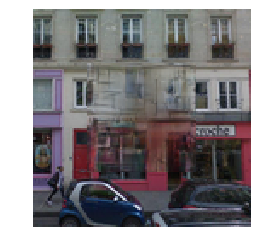

In [15]:
reconsPath = 'val_recon_samples.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


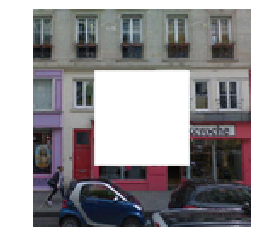

In [16]:
reconsPath = 'val_real_samples.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

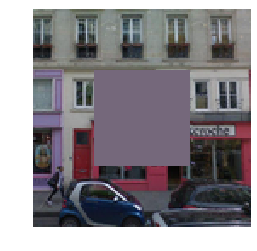

In [17]:
reconsPath = 'val_cropped_samples.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

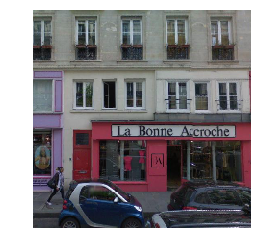

In [18]:
reconsPath = 'pytorch_12_xf/dataset/val/paris_eval_gt/001_im.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()